# Davis Drought

Author: Fan Hu


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

## CIMIS Daily

California Irrigation Management Information System (CIMIS)

Station Information **ID #6 Davis**: 
* North Central Region Office, Sacramento Valley Region, Yolo County
* Data Available from 7/17/1982
* ETo Reported; Reference Surface is Grass; Datalogger is CR1000
* **Elevation: 60 Feet**
* **Latitude: 38º32'8N / 38.535694**
* **Longitude: 121º46'35W / -121.776360**

In [2]:
df_temp = pd.read_csv('data/CIMIS_Davis_daily.csv')
df_temp = df_temp.replace(r'^\s$', np.NaN, regex=True) # replace the space in the "qc" columns with NaN
df_temp.columns

Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date', 'Jul', 'ETo (mm)', 'qc',
       'Precip (mm)', 'qc.1', 'Sol Rad (W/sq.m)', 'qc.2', 'Net Rad (W/sq.m)',
       'qc.3', 'Max Vap Pres (kPa)', 'qc.4', 'Min Vap Pres (kPa)', 'qc.5',
       'Avg Vap Pres (kPa)', 'qc.6', 'Max Air Temp (C)', 'qc.7',
       'Min Air Temp (C)', 'qc.8', 'Avg Air Temp (C)', 'qc.9',
       'Max Rel Hum (%)', 'qc.10', 'Min Rel Hum (%)', 'qc.11',
       'Avg Rel Hum (%)', 'qc.12', 'Dew Point (C)', 'qc.13',
       'Avg Wind Speed (m/s)', 'qc.14', 'Rose NNE', 'qc.15', 'Rose ENE',
       'qc.16', 'Rose ESE', 'qc.17', 'Rose SSE', 'qc.18', 'Rose SSW', 'qc.19',
       'Rose WSW', 'qc.20', 'Rose WNW', 'qc.21', 'Rose NNW', 'qc.22',
       'Wind Run (km)', 'qc.23', 'Max Soil Temp (C)', 'qc.24',
       'Min Soil Temp (C)', 'qc.25', 'Avg Soil Temp (C)', 'qc.26',
       'PM ETo (mm)', 'qc.27', 'PM ETr (mm)', 'qc.28', 'Batt Volt (VDC)',
       'qc.29', 'Exp 1', 'Exp 2'],
      dtype='object')

### Variables

**Daily Report** adds more sensors to the default available prior to logging in. By checking the box for sensors, you may access Daily Report’s 18 additional sensors, including: net radiation; maximum and minimum vapor pressures; eight wind rose values NNE, ENE, ESE, SSE, SSW, WSW, WNW, NNW; maximum and minimum soil temperatures; Penman-Monteith ETo and ETr; battery voltage, and two experimental sensors. The date range available includes data up to yesterday.

https://cimis.water.ca.gov/Resources.aspx see "Data Types"

* **Measured Values**: Solar Radiation, Air Temperature, Soil Temperature, Relative Humidity, Wind Speed, Wind Direction, Precipitation
* **Calculated Values**: Net Radiation, Reference Evapotranspiration (evapotranspiration from standardized grass (ETo) or alfalfa (ETr) surfaces), Resultant Wind Speed, Wind Rose, Wind Run, Vapor Pressure, Dew Point Temperature

Rendered in METRIC Units.

| QC Flag Legend | | |
| ----------- | ----------- | ----------- |
| A - Historical Average | I - Ignore | R - Far out of normal range |
| C or N - Not Collected | M - Missing Data| S - Not in service |
| H - Hourly Missing or Flagged Data| Q - Related Sensor Missing| Y - Moderately out of range |


In [3]:
df_temp_2 = df_temp.drop(columns=['Stn Id', 'Stn Name', 'CIMIS Region',
                                  'Rose NNE', 'qc.15', 'Rose ENE', 'qc.16', 
                                  'Rose ESE', 'qc.17', 'Rose SSE', 'qc.18', 
                                  'Rose SSW', 'qc.19', 'Rose WSW', 'qc.20', 
                                  'Rose WNW', 'qc.21', 'Rose NNW', 'qc.22',
                                  'Wind Run (km)', 'qc.23', 
                                  'PM ETo (mm)', 'qc.27', 'PM ETr (mm)', 'qc.28', # Too many missing data for ETo and ETr
                                  'Batt Volt (VDC)', 'qc.29', 'Exp 1', 'Exp 2'])

print("The total number of records before data cleaning is", df_temp_2.shape[0])

# Find the missing data for all columns
df_temp_2.loc[:, df_temp_2.columns[~df_temp_2.columns.str.startswith('qc')]].isnull().sum()


The total number of records before data cleaning is 14221


Date                      0
Jul                       0
ETo (mm)                  0
Precip (mm)             146
Sol Rad (W/sq.m)        144
Net Rad (W/sq.m)        295
Max Vap Pres (kPa)      163
Min Vap Pres (kPa)      221
Avg Vap Pres (kPa)      161
Max Air Temp (C)        147
Min Air Temp (C)        196
Avg Air Temp (C)        146
Max Rel Hum (%)          65
Min Rel Hum (%)          65
Avg Rel Hum (%)         201
Dew Point (C)           204
Avg Wind Speed (m/s)    149
Max Soil Temp (C)       406
Min Soil Temp (C)       527
Avg Soil Temp (C)       521
dtype: int64

In [4]:
# Find all the indices of the records after removing the NaN values of the variables
# and then pass them into df_temp_2

df_temp_2 = df_temp_2.loc[df_temp_2.loc[:, df_temp_2.columns[~df_temp_2.columns.str.startswith('qc')]].dropna().index]

print("The total number of records after 1st data cleaning is", df_temp_2.shape[0])

# See what qc flags remain
pd.unique(df_temp_2.loc[:, df_temp_2.columns[df_temp_2.columns.str.startswith('qc')]].values.ravel())


The total number of records after 1st data cleaning is 13255


array([nan, 'H', 'F', 'R', 'Y', 'I', 'E'], dtype=object)

In [5]:
cimis_all = df_temp_2.loc[:, df_temp_2.columns[~df_temp_2.columns.str.startswith('qc')]]#.iloc[:, 3:]
# cimis_all.isnull().sum()
cimis_all.reset_index(drop=True, inplace=True)
cimis_all['Date'] = pd.to_datetime(cimis_all['Date'], format='%m/%d/%Y')
cimis_all.head()

,Date,Jul,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Net Rad (W/sq.m),Max Vap Pres (kPa),Min Vap Pres (kPa),Avg Vap Pres (kPa),Max Air Temp (C),Min Air Temp (C),Avg Air Temp (C),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (C),Avg Wind Speed (m/s),Max Soil Temp (C),Min Soil Temp (C),Avg Soil Temp (C)
0,1982-09-22,265,4.11,84.0,248.0,107.0,1.8,0.7,1.4,36.8,11.1,21.1,94.0,19.0,56.0,11.9,1.7,21.5,19.7,20.6
1,1982-09-23,266,2.31,0.0,145.0,62.0,2.1,1.3,1.7,28.3,11.2,18.7,96.0,44.0,79.0,14.9,2.2,21.0,20.0,20.6
2,1982-09-24,267,2.46,0.0,143.0,75.0,2.5,1.9,2.1,31.0,17.9,21.7,93.0,62.0,82.0,18.5,1.5,22.3,20.7,21.4
3,1982-09-25,268,1.35,0.0,92.0,32.0,2.3,1.3,1.9,23.6,11.6,18.5,93.0,74.0,89.0,16.7,2.8,22.1,21.2,21.8
4,1982-09-26,269,3.30,0.0,225.0,102.0,1.7,1.1,1.4,28.4,8.9,16.6,96.0,42.0,73.0,11.8,1.9,21.6,20.2,20.9


## Gridded Surface Meteorological (gridMET) 
References:
_Abatzoglou J. T. "Development of gridded surface meteorological data for ecological applications and modelling". International Journal of Climatology. (2011) doi: 10.1002/joc.3413._

U.S. Gridded Palmer Drought Severity Index (**PDSI**) from gridMET

This new experimental implementation of the Palmer Drought Severity Index (PDSI) updates __every 5 days__ using the high-resolution gridMET gridded research dataset and USDA STATSGO soils data. The PDSI is a standardized index based on a simplified soil water balance and estimates relative soil moisture conditions. The magnitude of PDSI indicates the severity of the departure from normal conditions. A PDSI value >4 represents very wet conditions, while a PDSI <-4 represents an extreme drought. 

This PDSI uses a new methodology for sub-monthly PDSI, outlined in the Documentation section below.

https://www.drought.gov/data-maps-tools/us-gridded-palmer-drought-severity-index-pdsi-gridmet

PDSI and Palmer Z Index: https://www.ncdc.noaa.gov/temp-and-precip/drought/historical-palmers/overview
- Palmer Z Index: measures short-term drought on a monthly scale.
- Palmer Drought Severity Index: attempts to measure the duration and intensity of the long-term drought-inducing circulation patterns.

In [6]:
pdsi_davis = pd.read_csv('data/davis/pdsi_davis.csv', header=0)
pdsi_davis.columns=['DateTime', 'PDSI']
pdsi_davis['DateTime'] = pd.to_datetime(pdsi_davis['DateTime'], format='%Y-%m-%d')
pdsi_davis.head()

,DateTime,PDSI
0,1980-01-05,0.04
1,1980-01-10,0.10
2,1980-01-15,0.23
3,1980-01-20,0.56
4,1980-01-25,0.63


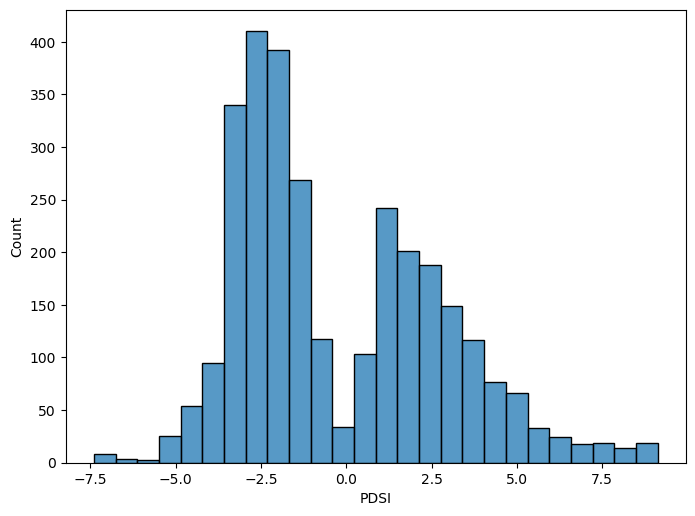

In [7]:
plt.figure(figsize=[8,6], dpi=100)
sns.histplot(data=pdsi_davis['PDSI']);

# plt.savefig("pdsi_hist.png")

## Combine CIMIS and PDSI

In [8]:
df_all = pd.merge(left=cimis_all, right=pdsi_davis, left_on='Date', right_on='DateTime')
df_all.drop(columns=['DateTime'], inplace=True)
df_all.head()

,Date,Jul,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Net Rad (W/sq.m),Max Vap Pres (kPa),Min Vap Pres (kPa),Avg Vap Pres (kPa),Max Air Temp (C),...,Avg Air Temp (C),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (C),Avg Wind Speed (m/s),Max Soil Temp (C),Min Soil Temp (C),Avg Soil Temp (C),PDSI
0,1982-09-22,265,4.11,84.0,248.0,107.0,1.8,0.7,1.4,36.8,...,21.1,94.0,19.0,56.0,11.9,1.7,21.5,19.7,20.6,4.94
1,1982-09-27,270,5.03,0.0,238.0,99.0,1.4,0.8,1.1,25.0,...,17.6,89.0,28.0,54.0,8.1,3.8,21.0,19.7,20.3,5.13
2,1982-10-02,275,3.41,0.0,214.0,88.0,1.5,0.7,1.1,31.0,...,17.1,92.0,21.0,55.0,7.8,1.5,19.1,17.3,18.2,5.29
3,1982-10-07,280,5.51,0.0,214.0,78.0,1.2,0.4,0.7,23.0,...,15.1,91.0,16.0,42.0,2.2,5.3,17.7,16.6,17.1,5.43
4,1982-10-12,285,3.23,132.0,193.0,76.0,1.4,0.7,1.0,32.5,...,18.1,84.0,18.0,46.0,6.4,0.9,19.4,17.9,18.7,5.54


In [9]:
from sklearn.model_selection import train_test_split

original_training_data, test = train_test_split(df_all, test_size=0.2, random_state=42)
train, val = train_test_split(original_training_data, test_size=0.1, random_state=0)

In [10]:
train.head()

,Date,Jul,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Net Rad (W/sq.m),Max Vap Pres (kPa),Min Vap Pres (kPa),Avg Vap Pres (kPa),Max Air Temp (C),...,Avg Air Temp (C),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (C),Avg Wind Speed (m/s),Max Soil Temp (C),Min Soil Temp (C),Avg Soil Temp (C),PDSI
714,1993-03-06,65,2.74,0.0,203.0,89.0,1.6,1.0,1.3,23.7,...,14.5,100.0,46.0,78.0,10.7,1.3,14.0,10.6,12.2,2.31
117,1984-06-23,175,8.88,0.0,343.0,230.0,1.8,0.7,1.2,35.4,...,24.5,73.0,14.0,41.0,10.2,2.5,25.6,20.0,22.5,2.88
895,1995-09-02,245,5.27,0.0,262.0,136.0,2.0,1.1,1.4,30.8,...,20.0,96.0,33.0,60.0,12.1,2.4,26.2,24.4,25.3,4.76
1554,2005-05-10,130,4.52,0.0,279.0,151.0,1.3,0.7,1.0,20.4,...,12.8,94.0,37.0,67.0,6.8,2.2,17.7,14.5,16.1,1.24
1085,1998-06-19,170,6.71,0.0,350.0,195.0,2.0,0.9,1.4,27.7,...,19.7,91.0,30.0,63.0,12.4,2.8,23.7,20.0,21.3,4.25


In [11]:
def get_X(data): 
    '''
    Define the pipeline function
    ''' 
    df = data.copy()    
    
    # Add more features
    df['Year'] = df['Date'].dt.year
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month    
    df['Day'] = df['Date'].dt.day
    
    # Return predictors and response variables separately
    X = df.drop(columns=["Date", "PDSI",])
#     scaler = StandardScaler().fit(X)
#     X = scaler.transform(X)      
    return X

def process_pipeline(data): 
    X = get_X(data)
    y = data.loc[:, 'PDSI']
    return X, y
    

X_1_train, y_1_train = process_pipeline(train)
X_1_val, y_1_val = process_pipeline(val)
X_1_test, y_1_test = process_pipeline(test)

In [12]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(max_depth=20, 
                                  n_estimators=30, 
                                  min_samples_leaf=1,
                                  min_samples_split=12,
                                  max_features='auto',
                                  bootstrap=False,
                                  random_state=3)
  
# fit the regressor with x and y data
regressor.fit(X_1_train, y_1_train)  
# Train : Test = 4 : 1

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=3, verbose=0,
                      warm_start=False)

In [13]:
X_1_train

,Jul,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Net Rad (W/sq.m),Max Vap Pres (kPa),Min Vap Pres (kPa),Avg Vap Pres (kPa),Max Air Temp (C),Min Air Temp (C),...,Avg Rel Hum (%),Dew Point (C),Avg Wind Speed (m/s),Max Soil Temp (C),Min Soil Temp (C),Avg Soil Temp (C),Year,Week,Month,Day
714,65,2.74,0.0,203.0,89.0,1.6,1.0,1.3,23.7,6.6,...,78.0,10.7,1.3,14.0,10.6,12.2,1993,9,3,6
117,175,8.88,0.0,343.0,230.0,1.8,0.7,1.2,35.4,13.2,...,41.0,10.2,2.5,25.6,20.0,22.5,1984,25,6,23
895,245,5.27,0.0,262.0,136.0,2.0,1.1,1.4,30.8,10.1,...,60.0,12.1,2.4,26.2,24.4,25.3,1995,35,9,2
1554,130,4.52,0.0,279.0,151.0,1.3,0.7,1.0,20.4,4.3,...,67.0,6.8,2.2,17.7,14.5,16.1,2005,19,5,10
1085,170,6.71,0.0,350.0,195.0,2.0,0.9,1.4,27.7,12.2,...,63.0,12.4,2.8,23.7,20.0,21.3,1998,25,6,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,160,6.35,0.0,317.0,181.0,2.0,1.2,1.5,30.4,12.2,...,63.0,13.4,2.7,27.9,22.0,24.6,1992,24,6,8
996,25,1.71,24.0,122.0,46.0,1.7,1.1,1.4,17.7,7.6,...,92.0,12.1,5.6,10.5,8.1,9.3,1997,4,1,25
1563,175,6.17,0.0,312.0,179.0,1.7,1.1,1.3,27.3,12.1,...,59.0,11.2,2.7,18.7,14.8,16.9,2005,25,6,24
1310,260,4.44,0.0,243.0,116.0,1.9,1.0,1.4,30.0,9.8,...,62.0,11.9,1.7,19.5,17.3,18.4,2001,38,9,17


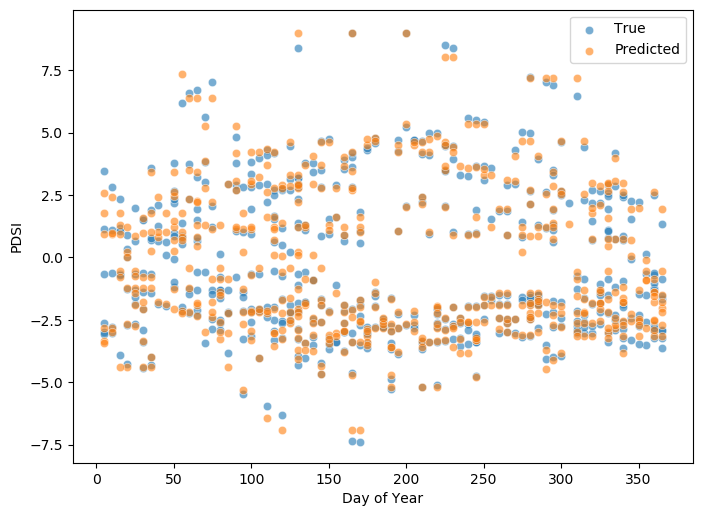

In [33]:
x_plot = X_1_test['Jul']
plt.figure(figsize=[8,6], dpi=100)
ax = sns.scatterplot(x = x_plot, y = y_1_test, alpha=0.6, label='True')
sns.scatterplot(x = x_plot, y = regressor.predict(X_1_test), alpha=0.6, label='Predicted');
ax.set(xlabel = 'Day of Year'); 
# plt.savefig("pdsi_day.png")

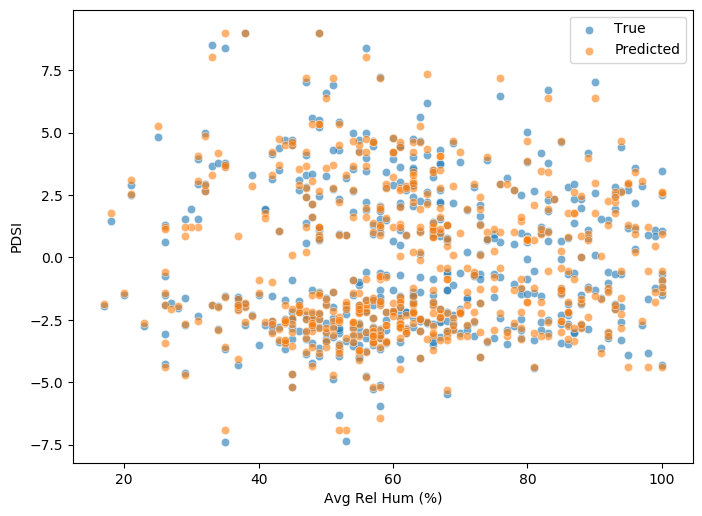

In [19]:
x_plot = X_1_test['Avg Rel Hum (%)']
plt.figure(figsize=[8,6], dpi=100)
sns.scatterplot(x = x_plot, y = y_1_test, alpha=0.6, label='True')
sns.scatterplot(x = x_plot, y = regressor.predict(X_1_test), alpha=0.6, label='Predicted');
# plt.savefig("pdsi_hum.png")

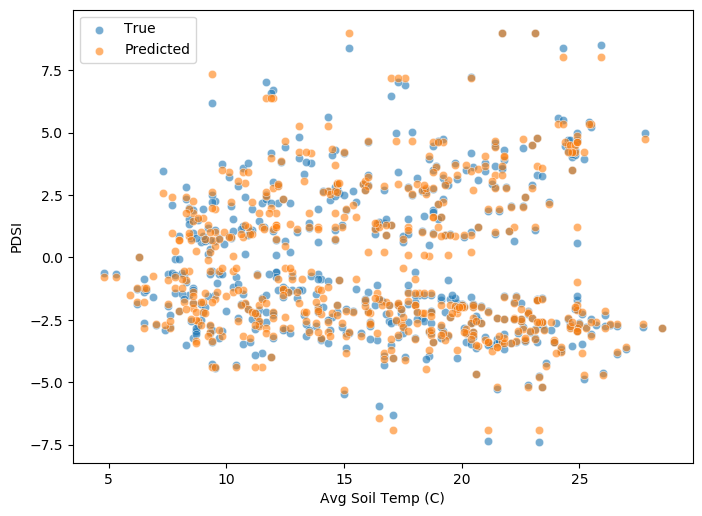

In [21]:
x_plot = X_1_test['Avg Soil Temp (C)']
plt.figure(figsize=[8,6], dpi=100)
sns.scatterplot(x = x_plot, y = y_1_test, alpha=0.6, label='True')
sns.scatterplot(x = x_plot, y = regressor.predict(X_1_test), alpha=0.6, label='Predicted');
# plt.savefig("pdsi_soil_tem.png")

In [262]:
def find_dr_level(s):
    s = pd.Series(s)
    pdsi = s.copy()
    pdsi.mask(s <= -5.0, 'D4', inplace=True)
    pdsi.mask((-5.0 < s) & (s <= -4.0), 'D3', inplace=True)
    pdsi.mask((-4.0 < s) & (s <= -3.0), 'D2', inplace=True)
    pdsi.mask((-3.0 < s) & (s <= -2.0), 'D1', inplace=True)
    pdsi.mask((-2.0 < s) & (s <= -1.0), 'D0', inplace=True)
    pdsi.mask(s > -1.0, 'Wet', inplace=True)
    return pdsi

def class_accuracy(X, y):
    N = len(y)
    eq_num = np.sum(find_dr_level(y).values == find_dr_level(regressor.predict(X)).values)
    return  eq_num / N

In [263]:
class_accuracy(X_1_test, y_1_test)

0.8679245283018868

In [264]:
y_1_test

1691   -3.94
1149    1.39
812    -2.84
1499   -1.09
1005    3.01
        ... 
527    -3.46
2147   -4.01
2474   -3.01
2572   -2.56
1811   -3.40
Name: PDSI, Length: 530, dtype: float64

## GHCND CA Stations

In [2]:
colspecs = [(0,11), (12,20), (21,30), (31,37), (38,40), (41,71), (72,75), (76,79), (80,85)]
ghcnd_stations = pd.read_fwf('data/ghcnd-stations.txt', colspecs=colspecs, header=None, index_col=None)
ghcnd_stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSNFLAG", "HCNFLAG", "WMOID"]

ghcnd_us_stations = ghcnd_stations.loc[ghcnd_stations['ID'].str.startswith('US')]
ghcnd_us_stations.set_index("ID", inplace=True)

ghcnd_ca_stations = ghcnd_us_stations.loc[ghcnd_us_stations['STATE'] == 'CA'].reset_index()
ghcnd_ca_stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSNFLAG,HCNFLAG,WMOID
0,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
3,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
4,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2874,USW00093241,38.3775,-121.9575,33.2,CA,VACAVILLE NUT TREE AP,NaN,NaN,NaN
2875,USW00093242,36.9878,-120.1106,77.1,CA,MADERA MUNI AP,NaN,NaN,NaN
2876,USW00093243,37.2381,-120.8825,23.8,CA,MERCED 23 WSW,NaN,NaN,74507.0
2877,USW00093245,38.3208,-123.0747,19.2,CA,BODEGA 6 WSW,NaN,NaN,74518.0


## Choose a station

In [3]:
station = 'USW00023232'
filename = 'data/CA_historical/'+station+'.csv.gz' 

### Location

In [4]:
import geopy

def get_address(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df.loc[:, lat_field].values, 
                                   df.loc[:, lon_field].values))
    return location.raw['address']

geolocator = geopy.Nominatim(user_agent="http")

pprint(get_address(ghcnd_ca_stations[ghcnd_ca_stations['ID'] == 'USW00023232'], 
            geolocator, 'LATITUDE', 'LONGITUDE'))

{'aeroway': 'Sacramento Executive Airport',
 'city': 'Sacramento',
 'country': 'United States',
 'country_code': 'us',
 'county': 'Sacramento County',
 'postcode': '95822',
 'road': 'Sterling Street',
 'state': 'California',
 'suburb': 'Parkway-South Sacramento'}


### Daily Weather

In [5]:
df_temp = pd.read_csv(filename, 
                      names=["ID", "DATE", "ELEMENT", "VALUE", "FLAG1", "FLAG2", "FLAG3", "FLAG4"], 
                      low_memory=False)
df_temp['DATE'] = pd.to_datetime(df_temp['DATE'], format='%Y%m%d')
df_temp = df_temp[(df_temp['DATE'] >= pd.Timestamp(2010, 1, 5)) 
                & (df_temp['DATE'] <= pd.Timestamp(2021, 1, 4))]
df = df_temp.pivot_table(index=["DATE"], columns=["ELEMENT"],values="VALUE")
df.reset_index(inplace=True)

# remove all columns full of NaN values
df.dropna(axis=1, how='all', inplace=True)

In [6]:
df

ELEMENT,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT03,WT05,WT07,WT08,WT09,WT10,WT13,WT16,WT21,WT22
0,2010-01-05,3.0,1031.0,1157.0,0.0,NaN,NaN,NaN,89.0,44.0,...,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN
1,2010-01-06,8.0,1910.0,1909.0,0.0,NaN,NaN,NaN,94.0,67.0,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,2010-01-07,7.0,1600.0,1025.0,0.0,NaN,NaN,NaN,100.0,72.0,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
3,2010-01-08,14.0,1226.0,1513.0,13.0,NaN,NaN,NaN,111.0,50.0,...,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN
4,2010-01-09,9.0,420.0,1331.0,0.0,NaN,NaN,NaN,100.0,72.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,2020-12-31,45.0,NaN,NaN,0.0,NaN,NaN,102.0,156.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4014,2021-01-01,18.0,NaN,NaN,3.0,NaN,NaN,82.0,128.0,17.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4015,2021-01-02,9.0,NaN,NaN,10.0,NaN,NaN,91.0,106.0,78.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4016,2021-01-03,7.0,NaN,NaN,0.0,NaN,NaN,98.0,139.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['DATE', 'AWND', 'FMTM', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX',
       'TMIN', 'WDF2', 'WDF5', 'WESD', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT05', 'WT07', 'WT08', 'WT09', 'WT10', 'WT13', 'WT16', 'WT21', 'WT22'],
      dtype='object', name='ELEMENT')

ELEMENT is the element type. There are five core elements as well as a number of addition elements.  
	   
The five core elements are:

       PRCP = Precipitation (tenths of mm)
       SNOW = Snowfall (mm)
	   SNWD = Snow depth (mm)
       TMAX = Maximum temperature (tenths of degrees C)
       TMIN = Minimum temperature (tenths of degrees C)
	   
The other elements are:
	   
	   ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
	   ACMH = Average cloudiness midnight to midnight from manual observations (percent)
       ACSC = Average cloudiness sunrise to sunset from 30-second ceilometer data (percent)
	   ACSH = Average cloudiness sunrise to sunset from manual observations (percent)
       AWDR = Average daily wind direction (degrees)
	   AWND = Average daily wind speed (tenths of meters per second)
	   DAEV = Number of days included in the multiday evaporation total (MDEV)
	   DAPR = Number of days included in the multiday precipiation total (MDPR)
       DASF = Number of days included in the multiday snowfall total (MDSF)		  
	   DATN = Number of days included in the multiday minimum temperature (MDTN)
	   DATX = Number of days included in the multiday maximum temperature (MDTX)
       DAWM = Number of days included in the multiday wind movement (MDWM)
	   DWPR = Number of days with non-zero precipitation included in multiday precipitation total (MDPR)
	   EVAP = Evaporation of water from evaporation pan (tenths of mm)
	   FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
	   FRGB = Base of frozen ground layer (cm)
	   FRGT = Top of frozen ground layer (cm)
	   FRTH = Thickness of frozen ground layer (cm)
	   GAHT = Difference between river and gauge height (cm)
	   MDEV = Multiday evaporation total (tenths of mm; use with DAEV)
	   MDPR = Multiday precipitation total (tenths of mm; use with DAPR and DWPR, if available)
	   MDSF = Multiday snowfall total 
	   MDTN = Multiday minimum temperature (tenths of degrees C; use with DATN)
	   MDTX = Multiday maximum temperature (tenths of degress C; use with DATX)
	   MDWM = Multiday wind movement (km)
       MNPN = Daily minimum temperature of water in an evaporation pan (tenths of degrees C)
       MXPN = Daily maximum temperature of water in an evaporation pan (tenths of degrees C)
	   PGTM = Peak gust time (hours and minutes, i.e., HHMM)
	   PSUN = Daily percent of possible sunshine (percent)
	   SN*# = Minimum soil temperature (tenths of degrees C)
	          where * corresponds to a code
	          for ground cover and # corresponds to a code for soil depth.  
		  
              Ground cover codes include the following:
              0 = unknown
              1 = grass
              2 = fallow
              3 = bare ground
              4 = brome grass
              5 = sod
              6 = straw multch
              7 = grass muck
              8 = bare muck
		  
              Depth codes include the following:
              1 = 5 cm
              2 = 10 cm
              3 = 20 cm
              4 = 50 cm
              5 = 100 cm
              6 = 150 cm
              7 = 180 cm
		  
	   SX*# = Maximum soil temperature (tenths of degrees C) 
	          where * corresponds to a code for ground cover and # corresponds to a code for soil depth. 
              See SN*# for ground cover and depth codes. 
      
       TAVG = Average temperature (tenths of degrees C)
	          [Note that TAVG from source 'S' corresponds to an average for the period ending at
		      2400 UTC rather than local midnight]
       THIC = Thickness of ice on water (tenths of mm)
       TOBS = Temperature at the time of observation (tenths of degrees C)
	   TSUN = Daily total sunshine (minutes)
	   WDF1 = Direction of fastest 1-minute wind (degrees)
	   WDF2 = Direction of fastest 2-minute wind (degrees)
	   WDF5 = Direction of fastest 5-second wind (degrees)
	   WDFG = Direction of peak wind gust (degrees)
	   WDFI = Direction of highest instantaneous wind (degrees)
	   WDFM = Fastest mile wind direction (degrees)
       WDMV = 24-hour wind movement (km)	   
       WESD = Water equivalent of snow on the ground (tenths of mm)
	   WESF = Water equivalent of snowfall (tenths of mm)
	   WSF1 = Fastest 1-minute wind speed (tenths of meters per second)
	   WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
	   WSF5 = Fastest 5-second wind speed (tenths of meters per second)
	   WSFG = Peak gust wind speed (tenths of meters per second)
	   WSFI = Highest instantaneous wind speed (tenths of meters per second)
	   WSFM = Fastest mile wind speed (tenths of meters per second)

       WT** = Weather Type where ** has one of the following values:
	   
              01 = Fog, ice fog, or freezing fog (may include heavy fog)
              02 = Heavy fog or heaving freezing fog (not always distinquished from fog)
              03 = Thunder
              04 = Ice pellets, sleet, snow pellets, or small hail 
              05 = Hail (may include small hail)
              06 = Glaze or rime 
              07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
              08 = Smoke or haze 
              09 = Blowing or drifting snow
              10 = Tornado, waterspout, or funnel cloud 
              11 = High or damaging winds
              12 = Blowing spray
              13 = Mist
              14 = Drizzle
              15 = Freezing drizzle 
              16 = Rain (may include freezing rain, drizzle, and freezing drizzle) 
              17 = Freezing rain 
              18 = Snow, snow pellets, snow grains, or ice crystals
              19 = Unknown source of precipitation 
              21 = Ground fog 
              22 = Ice fog or freezing fog
		  
       WV** = Weather in the Vicinity where ** has one of the following values:
		   
              01 = Fog, ice fog, or freezing fog (may include heavy fog)
              03 = Thunder
              07 = Ash, dust, sand, or other blowing obstruction
              18 = Snow or ice crystals
              20 = Rain or snow shower

In [8]:
df['SNWD'].value_counts()

0.0    685
Name: SNWD, dtype: int64